# Lending Club Predictive Credit Models

**Intro**: Lending Club is an online Peer-to-Peer lender connecting borrowers and investors. They provide public data on the performance of their loans over time to provide transparency to the users of their online market place and curious data scientists. We can use this data to build our own credit model for the purpose of underwriting loans.

**Objective**: Create a model to predict the probability of credit default on Lending Club loans originated between 2007-2011. These are a mix of prime and subprime loans designated by the Lending Club "grade" (A, B, F, G). You are encouraged to play around with different types of feature engineering, modeling techniques, and validation framesworks toward the aim of maximizing loan performance on a test set.

In [87]:
import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import missingno as mn

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, make_scorer, confusion_matrix, f1_score

## Performance Metric

We use AUC (Area-under-the-curve) as an optimization metric. This is a popular metric within credit modeling.

In [88]:
def get_auc(y_true, y_pred):
    # y: an array of labels marking the actualy result as default (1) or non-default (0) 
    # y_pred: a probability that a row has defaulted
    # fpr: false-positive rate
    # tpr: true-positive rate
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score

## Load Data from csv

In [89]:
# read csv (441.8 MB)
loan = pd.read_csv("../data/loan.csv", low_memory=False)
# check dimension
print loan.shape

(887379, 74)


In [90]:
# check column names
loan.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan',
       u'url', u'desc', u'purpose', u'title', u'zip_code', u'addr_state',
       u'dti', u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'application_type',
       u'annu

## Set up response variable

In [91]:
# all categories of loan_status
loan['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Since we focus only on __closed deals__, we keep rows with a loan status of _"Fully Paid", "Charged Off" and "Default"_. Then we delete all other entries. 

In [92]:
# filter response categories
loan = loan[(loan['loan_status']=="Fully Paid") | (loan['loan_status']=="Charged Off") | (loan['loan_status']=="Default")]
# set up binary response variable
default = loan['loan_status'].map({"Fully Paid": 0.0,"Charged Off": 1.0,"Default": 1.0})
# delete loan_status from data frame
loan.drop('loan_status', axis=1, inplace=True)
# check dimension
loan.shape

(254190, 73)

## Drop variables

In [93]:
# drop irrelavent variables
loan.drop(['id','member_id', 'emp_title', 'desc', 'url', 'title', 'zip_code'], axis=1, inplace=True)
# check dimension
loan.shape

(254190, 66)

## Check missing values

In [94]:
# NA count table
NAs = pd.concat([loan.isnull().sum(), np.round(loan.isnull().sum()/len(loan), 2)], axis=1, keys=['missing counts','missing percentage'])

In [95]:
NAs[0:25]

,missing counts,missing percentage
loan_amnt,0,0.00
funded_amnt,0,0.00
funded_amnt_inv,0,0.00
term,0,0.00
int_rate,0,0.00
installment,0,0.00
grade,0,0.00
sub_grade,0,0.00
emp_length,0,0.00
home_ownership,0,0.00


In [96]:
NAs[25:50]

,missing counts,missing percentage
revol_util,200,0.00
total_acc,0,0.00
initial_list_status,0,0.00
out_prncp,0,0.00
out_prncp_inv,0,0.00
total_pymnt,0,0.00
total_pymnt_inv,0,0.00
total_rec_prncp,0,0.00
total_rec_int,0,0.00
total_rec_late_fee,0,0.00


In [97]:
NAs[50:67]

,missing counts,missing percentage
tot_cur_bal,63726,0.25
open_acc_6m,254046,1.00
open_il_6m,254046,1.00
open_il_12m,254046,1.00
open_il_24m,254046,1.00
mths_since_rcnt_il,254050,1.00
total_bal_il,254046,1.00
il_util,254064,1.00
open_rv_12m,254046,1.00
open_rv_24m,254046,1.00


We drop variables that have over half NAs.

In [112]:
# drop NA variables
loan.drop(['mths_since_last_delinq', 'mths_since_last_record',
           'mths_since_last_major_derog', 'next_pymnt_d',
           'annual_inc_joint','dti_joint', 'verification_status_joint',
           'open_acc_6m', 'open_il_6m', 'open_il_24m', 'open_il_12m',
           'mths_since_rcnt_il', 'total_bal_il', 'il_util',
           'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
           'inq_fi', 'total_cu_tl', 'inq_last_12m'
          ], axis=1, inplace=True)
# check dimension
loan.shape

(254190, 42)

Further drop variables that have over 20% of NAs.

In [ ]:
# drop NA variables
loan.drop(['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'], axis=1, inplace=True)
# check dimension
loan.shape

## Data Cleaning & Feature engineering

1. generate new variable using existing variables
2. drop redundant variables
3. change variable to proper data type

__loan_amnt, funded_amnt, funded_amnt_inv__

In [119]:
print sum(loan['loan_amnt'] != loan['funded_amnt'])
# only 2062 rows have different values for loan_amnt and funded_amnt
# delete funded_amnt
loan.drop('funded_amnt', axis=1, inplace=True)

# add variable perc_funded_inv: The amount committed by investors divided by total loan amount.
loan['perc_funded_inv'] = loan['funded_amnt_inv'] / loan['loan_amnt']
# delete funded_amnt_inv
loan.drop('funded_amnt_inv', axis=1, inplace=True)

1773


__grade, sub_grade__

In [120]:
print loan['grade'].unique()
print loan['sub_grade'].unique()
print len(loan['sub_grade'].unique())

# map the grades to a continuous variable
loan['grade_num'] = loan['sub_grade'].map({'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,
                      'B1':6,'B2':7,'B3':8,'B4':9,'B5':10,
                      'C1':11,'C2':12,'C3':13,'C4':14,'C5':15,
                      'D1':16,'D2':17,'D3':18,'D4':19,'D5':20,
                      'E1':21,'E2':22,'E3':23,'E4':24,'E5':25,
                      'F1':26,'F2':27,'F3':28,'F4':29,'F5':30,
                      'G1':31,'G2':32,'G3':33,'G4':34,'G5':35,})

# delete grade, sub_grade
loan.drop(['grade', 'sub_grade'], axis=1, inplace=True)

['B' 'C' 'A' 'E' 'F' 'D' 'G']
['B2' 'C4' 'C5' 'C1' 'A4' 'E1' 'F2' 'B5' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F1' 'E5' 'G4' 'E2' 'G2'
 'G1' 'F5' 'F4' 'G5' 'G3']
35


__emp_length__: Variable emp_length has 11 categories, we cut the them into 4 different ranges.

In [121]:
# before cut
print loan['emp_length'].value_counts()

# cut
loan['emp_length'] = loan['emp_length'].map({'10+ years': '10+ years',
                       '9 years': '6-9 years',
                       '8 years': '6-9 years',
                       '7 years': '6-9 years',
                       '6 years': '6-9 years',
                       '5 years': '3-5 years',
                       '4 years': '3-5 years',
                       '3 years': '3-5 years',
                       '2 years': '0-2 years',
                       '1 year': '0-2 years',
                       '< 1 year': '0-2 years',
                       'n/a': '0-2 years' # no employment information
                      })

# after cut
print loan['emp_length'].value_counts()

10+ years    77256
2 years      23647
< 1 year     20975
3 years      20484
5 years      18136
1 year       16951
4 years      16263
6 years      14816
7 years      14156
8 years      11922
n/a           9968
9 years       9616
Name: emp_length, dtype: int64
10+ years    77256
0-2 years    71541
3-5 years    54883
6-9 years    50510
Name: emp_length, dtype: int64


__pymnt_plan, policy_code, application_type__: Alomost constant. Drop them.

In [142]:
# drop almost-constant variables
print loan['pymnt_plan'].value_counts()
print loan['policy_code'].value_counts()
print loan['application_type'].value_counts()

# delete them
loan.drop(['pymnt_plan', 'policy_code', 'application_type'], axis=1, inplace=True)

n    254188
y         2
Name: pymnt_plan, dtype: int64
1.0    254190
Name: policy_code, dtype: int64
INDIVIDUAL    254189
JOINT              1
Name: application_type, dtype: int64


__issue_d, earliest_cr_line__: take the difference to get the number of days since earliest credit line.

In [143]:
# convert to date
loan['issue_d'] = pd.to_datetime(loan['issue_d'])
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])

# take the difference
loan['days_since_earliest_cr_line'] = loan['issue_d'] - loan['earliest_cr_line']

# drop issue_d and earliest_cr_line
loan.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)

__last_pymnt_d, last_credit_pull_d__: take the difference.

In [144]:
# convert to date
loan['last_pymnt_d'] = pd.to_datetime(loan['last_pymnt_d'])
loan['last_credit_pull_d'] = pd.to_datetime(loan['last_credit_pull_d'])

# take the difference
loan['days_diff_last_pymnt_pull'] = loan['last_credit_pull_d'] - loan['last_pymnt_d']

# drop issue_d and earliest_cr_line
loan.drop(['last_pymnt_d', 'last_credit_pull_d'], axis=1, inplace=True)

Now check data types.

In [154]:
# NA count table
print loan.shape
NAs = pd.concat([loan.dtypes, loan.isnull().sum(), np.round(loan.isnull().sum()/len(loan), 2)], axis=1, keys=['Type', 'missing counts','missing percentage'])
NAs

(254190, 35)


,Type,missing counts,missing percentage
loan_amnt,float64,0,0.0
term,object,0,0.0
int_rate,float64,0,0.0
installment,float64,0,0.0
emp_length,object,0,0.0
home_ownership,object,0,0.0
annual_inc,float64,0,0.0
verification_status,object,0,0.0
purpose,object,0,0.0
addr_state,object,0,0.0


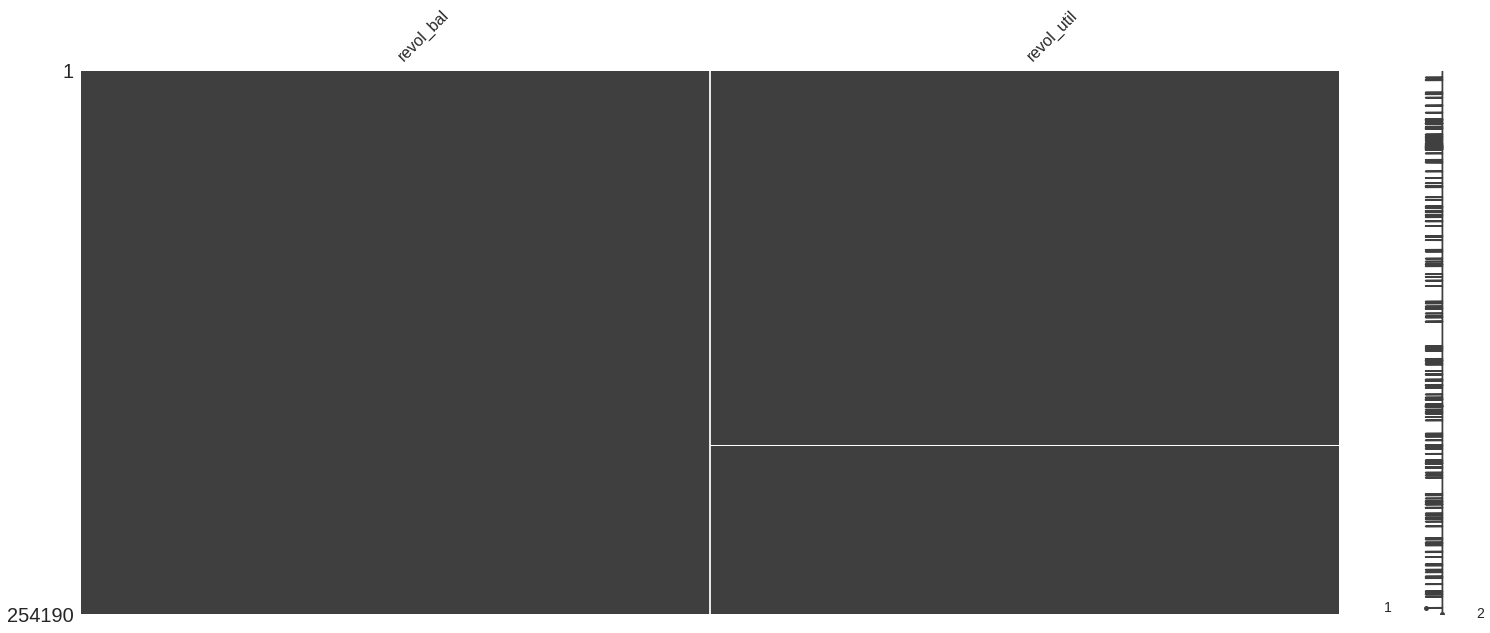

In [159]:
mn.matrix(loan[['revol_bal','revol_util']])

In [160]:
len(default)

254190